# Stellar Mass Functions (SMFs)

In [10]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from astropy.table import \
    Table, \
    Column, \
    vstack, \
    unique
    
from astropy.cosmology import FlatLambdaCDM

import glob
import os
import pickle
    
plt.rc('text', usetex=True)

In [11]:
#change order of default colors for Illustris and TNG
#colors= plt.rcParams['axes.prop_cycle'].by_key()['color']
import matplotlib as mpl
from cycler import cycler
colors=[u'#ff7f0e', u'#2ca02c', u'#9467bd', u'#d62728', u'#1f77b4', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']
mpl.rcParams['axes.prop_cycle'] = cycler(color=colors)

In [12]:
illustris_color = colors[3]
tng_color = colors[4]

## Modified (from Song) SMF functions

In [13]:
def compute_smf(log_masses, volume, n_bins, min_mass=None, max_mass=None):
    """
    Parameters
    ----------
    log_masses: ndarray
        Array of stellar mass values in log10 values

    volume : float
        volume of data in comoving Mpc^3

    n_bins : number of bins

    min_mass : min mass

    max_mass : max mass

    Returns
    -------
    m_centers : ndarray
        mass bin centers (x axis of SMF) in units of log10 M*

    log_phi : ndarray in units of dn / dlogM* in units of Mpc^-3 dex^-1

    log_err : ndarray
        log of Poisson error
    """
    if not min_mass:
        min_mass = min(log_masses)
    if not max_mass:
        max_mass = max(log_masses)
        
    Phi,edg = np.histogram(log_masses,bins=n_bins, range=[min_mass, max_mass]) #Unnormalized histogram and bin edges
    # Poisson error
    err = np.sqrt(Phi)
    
    #Bin size
    dM    = edg[1] - edg[0]                 
    m_centers   = edg[0:-1] + dM/2.           
    
    #Normalize to volume and bin size
    Phi   = Phi / float(volume) / dM        
    log_phi= np.log10(Phi) 

    # Also normalize the error
    err = err / float(volume) / dM 
    
    return m_centers, Phi, err


def bootstrap_smf(log_masses, volume, n_bins, min_mass, max_mass,
                  n_boots=1000, sm_err=None, resample_err=False):
    """
    Parameters
    ----------
    log_masses: ndarray
        Array of stellar mass values in log10 values

    volume : float
        volume of data in comoving Mpc^3

    n_bins : number of bins

    min_mass : min mass

    max_mass : max mass

    sm_err: ndarray, optional
        Array of stellar mass errors


    Returns
    -------
    m_centers : ndarray
        mass bin centers (x axis of SMF) in units of log10 M*

    log_phi : ndarray in units of dn / dlogM* in units of Mpc^-3 dex^-1

    log_err : ndarray
        log of Poisson error
        
    log_boot_err : ndarray
        log of Poisson error


    """

    m_centers, phi, err_poisson = compute_smf(log_masses, volume, n_bins, min_mass, max_mass)

    if resample_err:
        msg = "Need to provide the error of stellar mass!"
        assert sm_err is not None, msg
        sm_boots = np.asarray(map(lambda mass, err: np.random.normal(mass, err, n_boots),
                log_masses, sm_err))
    else:
        mass_boot_samples = bootstrap_resample(log_masses, n_boots=n_boots)

    phi_boots = np.vstack(compute_smf(mass_boot_samples[:, ii], volume, n_bins, sm_min, sm_max)[1] 
                              for ii in range(n_boots))
    
    #bootstrap error
    err_bootstrap=np.nanstd(phi_boots, axis=0)
    log_err_bootstrap=np.nanstd(np.log10(phi_boots[phi_boots != 0.0]), axis=0)
    
    
    
    return m_centers, phi, err_poisson, err_bootstrap, log_err_bootstrap, phi_boots

In [14]:
def open_pkl(file_name):
    pkl = open(file_name,'rb')
    array = pickle.load(pkl)
    pkl.close()  
    return array

## Read masses

In [15]:
#data
# Illustris_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/galaxies_orig_11.2.hdf5'
# TNG_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/galaxies_tng75_11.2.hdf5'
tng_masses_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_masses_highres.pkl'
illustris_masses_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/Illustris_masses_highres.pkl'
BAHAMAS_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/BAHAMAS/bahamas_z0.38_aperture_masses.fits'
Massive_Black_II_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/MassiveBlack-II/mblack2_z0.30_aperture_masses.fits'
Horizon_AGN_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Horizon-AGN/horizon_z0.37_aperture_masses.fits'

HSC_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/HSC/s16a_wide_massive_fastlane_imgsub_master_use_camira.fits'

In [16]:
tng_masses = open_pkl(tng_masses_file)
illustris_masses = open_pkl(illustris_masses_file)

volume_illustris=106.5**3 #Mpc^3
z_illustris = 0.4

In [17]:
tng_masses[0]

m_1d_10,m_1d_30,m_1d_100,m_1d_500,m_1d_800,m_2d_10,m_2d_30,m_2d_100,m_2d_500,m_2d_800,extrapolated_m_300,extrapolated_m_500,extrapolated_m_800,m_cat,m_post,m_post_icl
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
11.76024172759147,12.093535699995554,12.289991662656853,12.380527665748408,12.380527665748408,11.77350757938413,12.101761879109436,12.303738186458856,12.377627652942456,12.377627652942456,12.409390191068832,12.445570328574874,12.472189976011201,12.449948294587058,12.377627652227904,12.377636378979057


#### other sims
(from Song's notebook `s16a_mblack2_smf_compare.ipynb`)

In [18]:
# h0 
HSMALL = 0.70
H0 = 70.0

# MassiveBlack-2
ZMBLACK2 = 0.30
SMBLACK2 = 100.0  # Mpc
# Bahamas simulation
ZBAHAMAS = 0.38
SBAHAMAS = 250.0  # Mpc
SBAHAMAS = 100.0
# Horizon
ZHORIZON = 0.37
SHORIZON = 100.0  # Mpc

# S16A 
S16A_AREA = 144.7  # deg^2

In [19]:
#MassiveBlack-II
mblack2 = Table.read(Massive_Black_II_file, format='fits')
volMBlack2 = (SMBLACK2 / HSMALL) ** 3.0  # Mpc**3
print("# Volume for MassiveBlack-II : %f Mpc^3" % volMBlack2)

# Volume for MassiveBlack-II : 2915451.895044 Mpc^3


In [20]:
#BAHAMAS
bahamas = Table.read(BAHAMAS_file, format='fits')
volBahamas = (SBAHAMAS / HSMALL) ** 3.0  # Mpc**3
print("# Volume for Bahamas : %f Mpc^3" % volBahamas)

# Volume for Bahamas : 2915451.895044 Mpc^3


In [21]:
#Horizon-AGN
horizon = Table.read(Horizon_AGN_file, format='fits')
volHorizon = (SHORIZON / HSMALL) ** 3.0  # Mpc**3
print("# Volume for Horizon : %f Mpc^3" % volHorizon)
horizon.add_column(Column(np.log10(horizon['col6']), name='logm_3d')) #col6 -> 3D mass

# Volume for Horizon : 2915451.895044 Mpc^3


## SMFs 

#### Illustris & TNG 

In [22]:
n_bins = 5

m10_illustris, smf10_illustris, err10_illustris = compute_smf(illustris_masses['m_1d_10'], volume_illustris, n_bins=6, 
                                                              min_mass=11.2)
m10_tng, smf10_tng, err10_tng = compute_smf(tng_masses['m_1d_10'], volume_illustris,n_bins=3, min_mass=11.2)

m30_illustris, smf30_illustris, err30_illustris = compute_smf(illustris_masses['m_1d_30'], volume_illustris,n_bins,
                                                              min_mass=11.2)
m30_tng, smf30_tng, err30_tng = compute_smf(tng_masses['m_1d_30'], volume_illustris,n_bins, min_mass=11.2)

m100_illustris, smf100_illustris, err100_illustris = compute_smf(illustris_masses['m_1d_100'], volume_illustris,n_bins,
                                                              min_mass=11.2)
m100_tng, smf100_tng, err100_tng = compute_smf(tng_masses['m_1d_100'], volume_illustris,n_bins, min_mass=11.2)



#### other sims 

In [23]:
print max(mblack2['logmstar'])
print min(mblack2['logmstar'])

print max(bahamas['logM100_3D'])
print min(bahamas['logM100_3D'])

print max(horizon['logm_3d'])
print min(horizon['logm_3d'])

12.931872
11.400309
12.122
11.501
12.402911048030832
11.477378859697003


In [25]:
print('M_10')
print('Horizon: ', np.sum(horizon['m10_aper']>11.2), np.log10(volHorizon))
print('BAHAMAS: ',np.sum(bahamas['m10_aper']>11.2), np.log10(volBahamas))
print('MBlack2: ',np.sum(mblack2['m10_aper']>11.2), np.log10(volMBlack2))
print('Illustris: ',np.sum(illustris_masses['m_1d_10']>11.2), np.log10(volume_illustris))
print('TNG: ',np.sum(tng_masses['m_1d_10']>11.2), np.log10(volume_illustris))
print('---------------------------')

print('M_30')
print('Horizon: ', np.sum(horizon['m30_aper']>11.2), np.log10(volHorizon))
print('BAHAMAS: ',np.sum(bahamas['m30_aper']>11.2), np.log10(volBahamas))
print('MBlack2: ',np.sum(mblack2['m30_aper']>11.2), np.log10(volMBlack2))
print('Illustris: ',np.sum(illustris_masses['m_1d_30']>11.2), np.log10(volume_illustris))
print('TNG: ',np.sum(tng_masses['m_1d_30']>11.2), np.log10(volume_illustris))
print('---------------------------')

print('M_100')
print('Horizon: ', np.sum(horizon['m100_aper']>11.2), np.log10(volHorizon))
print('BAHAMAS: ',np.sum(bahamas['m100_aper']>11.2), np.log10(volBahamas))
print('MBlack2: ',np.sum(mblack2['m100_aper']>11.2), np.log10(volMBlack2))
print('Illustris: ',np.sum(illustris_masses['m_1d_100']>11.2), np.log10(volume_illustris))
print('TNG: ',np.sum(tng_masses['m_1d_100']>11.2), np.log10(volume_illustris))

M_10
('Horizon: ', 35, 6.464705879957229)
('BAHAMAS: ', 66, 6.464705879957229)
('MBlack2: ', 96, 6.464705879957229)
('Illustris: ', 113, 6.0820488233242695)
('TNG: ', 52, 6.0820488233242695)
---------------------------
M_30
('Horizon: ', 259, 6.464705879957229)
('BAHAMAS: ', 133, 6.464705879957229)
('MBlack2: ', 235, 6.464705879957229)
('Illustris: ', 257, 6.0820488233242695)
('TNG: ', 149, 6.0820488233242695)
---------------------------
M_100
('Horizon: ', 265, 6.464705879957229)
('BAHAMAS: ', 133, 6.464705879957229)
('MBlack2: ', 289, 6.464705879957229)
('Illustris: ', 307, 6.0820488233242695)
('TNG: ', 208, 6.0820488233242695)


In [26]:
m_MB2, smf_MB2, err_MB2 = compute_smf(mblack2['logmstar'], volMBlack2, n_bins)
m_BAHAMAS, smf_BAHAMAS, err_BAHAMAS = compute_smf(bahamas['logM100_3D'], volBahamas, n_bins)
m_horizon, smf_horizon, err_horizon = compute_smf(horizon['logm_3d'], volHorizon, n_bins)

m10_MB2, smf10_MB2, err10_MB2 = compute_smf(mblack2['m10_aper'], volMBlack2, n_bins=4, min_mass=11.2)
m10_BAHAMAS, smf10_BAHAMAS, err10_BAHAMAS = compute_smf(bahamas['m10_aper'], volBahamas, n_bins=4, min_mass=11.2)
m10_horizon, smf10_horizon, err10_horizon = compute_smf(horizon['m10_aper'], volHorizon, n_bins=3, min_mass=11.2)

m30_MB2, smf30_MB2, err30_MB2 = compute_smf(mblack2['m30_aper'], volMBlack2, n_bins=5, min_mass=11.2)
m30_BAHAMAS, smf30_BAHAMAS, err30_BAHAMAS = compute_smf(bahamas['m30_aper'], volBahamas, n_bins=3)
m30_horizon, smf30_horizon, err30_horizon = compute_smf(horizon['m30_aper'], volHorizon, n_bins=3, min_mass=11.2)

m100_MB2, smf100_MB2, err100_MB2 = compute_smf(mblack2['m100_aper'], volMBlack2, n_bins=5, min_mass=11.2)
m100_BAHAMAS, smf100_BAHAMAS, err100_BAHAMAS = compute_smf(bahamas['m100_aper'], volBahamas, n_bins=4)
m100_horizon, smf100_horizon, err100_horizon = compute_smf(horizon['m100_aper'], volHorizon, n_bins=5)

#### HSC 

In [27]:
#HSC
fastMaster = Table.read(HSC_file, format='fits')

print max(fastMaster['MSTAR'])
print min(fastMaster['MSTAR'])
print len(fastMaster['MSTAR'])

12.263241
10.752697
10293


In [28]:
# Stellar mass function
cosmo = FlatLambdaCDM(H0=H0, Om0=0.300)
s16a_vol = ((cosmo.comoving_volume(0.52) - cosmo.comoving_volume(0.19)) * 
            (S16A_AREA / 41253.0)).value
print("# Volume for HSC : %f Mpc^3" % s16a_vol)
m_hsc, smf_hsc, err_hsc = compute_smf(fastMaster['MSTAR'], s16a_vol, n_bins=15, min_mass=11.2)

m100_hsc, smf100_hsc, err100_hsc = compute_smf(fastMaster['logm_100'], s16a_vol, n_bins=15, min_mass=11.5)
m30_hsc, smf30_hsc, err30_hsc = compute_smf(fastMaster['logm_30'], s16a_vol, n_bins=15, min_mass=11.4)
m10_hsc, smf10_hsc, err10_hsc = compute_smf(fastMaster['logm_10'], s16a_vol, n_bins=15, min_mass=11.2)

s16aMLow1 = np.nanpercentile(smf_hsc, 3.0, axis=0)
s16aMUpp1 = np.nanpercentile(smf_hsc, 97.0, axis=0)
s16aMMed1 = np.nanmedian(smf_hsc, axis=0)

# Volume for HSC : 102650636.444615 Mpc^3


/Users/fardila/anaconda2/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log10


## test PLOTS


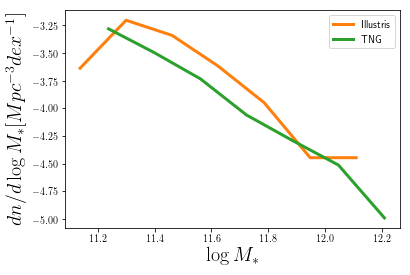

In [16]:
plt.plot(m_illustris,np.log10(smf_illustris), linewidth=3, label='Illustris')
plt.plot(m_tng,np.log10(smf_tng), linewidth=3, label='TNG')

# plt.fill_between(m_illustris,np.log10(smf_illustris+10*err_illustris), np.log10(smf_illustris-10*err_illustris)) #Poisson error smaller than line
# plt.fill_between(m_tng,np.log10(smf_tng+10*err_tng), np.log10(smf_tng-10*err_tng)) #Poisson error smaller than line

plt.xlabel(r'$\log{M_*}$', fontsize=20)
plt.ylabel(r'$dn / d\log{M_*}[Mpc^{-3} dex^{-1}]$', fontsize=20)
plt.legend()
plt.show()


In [25]:
np.linspace(11.2,12.2,7)

array([11.2       , 11.36666667, 11.53333333, 11.7       , 11.86666667,
       12.03333333, 12.2       ])

In [23]:
print err_hsc
print(m_hsc, np.log10(smf_hsc-err_hsc), np.log10(smf_hsc+err_hsc))

[4.88310424e-07 1.75425021e-06 2.88500075e-06 2.71729776e-06
 1.34527028e-06 3.66754146e-07 1.00945756e-07]
(array([10.86059298, 11.07638495, 11.29217693, 11.5079689 , 11.72376088,
       11.93955285, 12.15534483]), array([-5.31934053, -4.17774255, -3.74116075, -3.79360444, -4.41180809,
       -5.58289872, -6.90386958]), array([-5.23880949, -4.15538513, -3.72756801, -3.77917265, -4.3826492 ,
       -5.47543786, -6.4858943 ]))


In [24]:
print err_hsc
print(m_hsc, np.log10(smf_hsc-err_hsc), np.log10(smf_hsc+err_hsc))

[4.88310424e-07 1.75425021e-06 2.88500075e-06 2.71729776e-06
 1.34527028e-06 3.66754146e-07 1.00945756e-07]
(array([10.86059298, 11.07638495, 11.29217693, 11.5079689 , 11.72376088,
       11.93955285, 12.15534483]), array([-5.31934053, -4.17774255, -3.74116075, -3.79360444, -4.41180809,
       -5.58289872, -6.90386958]), array([-5.23880949, -4.15538513, -3.72756801, -3.77917265, -4.3826492 ,
       -5.47543786, -6.4858943 ]))


In [26]:
print(min(illustris_m_1d_10),min(illustris_m_1d_30),min(illustris_m_1d_100))
print(min(tng_m_1d_10),min(tng_m_1d_30),min(tng_m_1d_100))

(9.945799724109353, 10.69746642958277, 11.070460533732103)
(10.800397261867788, 11.0283259499358, 11.15698207241586)


([array([  1.,   0.,   0.,   0.,  14.,  97., 135.,  64.,  23.,   5.]),
  array([  0.,   0.,   0.,   0.,   7., 111.,  75.,  26.,   9.,   7.])],
 array([10.00306847, 10.1787858 , 10.35450313, 10.53022045, 10.70593778,
        10.8816551 , 11.05737243, 11.23308975, 11.40880708, 11.5845244 ,
        11.76024173]),
 <a list of 2 Lists of Patches objects>)

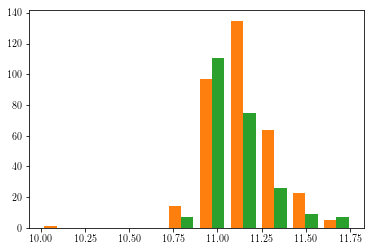

In [20]:
plt.hist([illustris_masses['m_1d_10'],tng_masses['m_1d_10']])

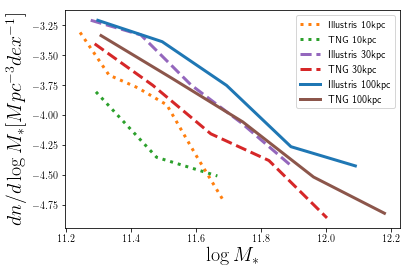

In [31]:
plt.plot(m10_illustris,np.log10(smf10_illustris), linewidth=3, label='Illustris 10kpc', linestyle=':')
plt.plot(m10_tng,np.log10(smf10_tng), linewidth=3, label='TNG 10kpc', linestyle=':')

plt.plot(m30_illustris,np.log10(smf30_illustris), linewidth=3, label='Illustris 30kpc', linestyle='--')
plt.plot(m30_tng,np.log10(smf30_tng), linewidth=3, label='TNG 30kpc', linestyle='--')

plt.plot(m100_illustris,np.log10(smf100_illustris), linewidth=3, label='Illustris 100kpc')
plt.plot(m100_tng,np.log10(smf100_tng), linewidth=3, label='TNG 100kpc')


plt.xlabel(r'$\log{M_*}$', fontsize=20)
plt.ylabel(r'$dn / d\log{M_*}[Mpc^{-3} dex^{-1}]$', fontsize=20)
plt.legend()
plt.show()

In [ ]:
# Horizon
plt.plot(m10_horizon, np.log10(smf10_horizon), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{HorizonAGN}$')
plt.fill_between(m10_horizon, np.log10(smf10_horizon-err10_horizon), np.log10(smf10_horizon+err10_horizon), alpha=0.3, rasterized=True)


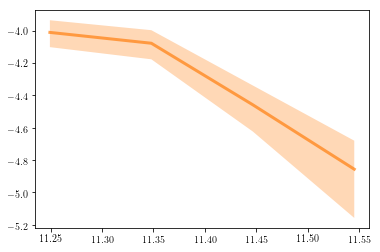

In [33]:
# Bahamas
plt.plot(m10_BAHAMAS, np.log10(smf10_BAHAMAS), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{BAHAMAS}$')
plt.fill_between(m10_BAHAMAS, np.log10(smf10_BAHAMAS-err10_BAHAMAS), np.log10(smf10_BAHAMAS+err10_BAHAMAS), 
                 alpha=0.3, rasterized=True)


### distributions of M_10 

/Users/fardila/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


([array([ 0.01839197,  0.        ,  0.        ,  0.        ,  0.20231163,
          1.56331716,  1.91276453,  1.103518  ,  0.3862313 ,  0.1655277 ]),
  array([ 0.        ,  0.04024107,  0.        ,  0.        ,  0.16096428,
          0.72433926,  2.01205349,  1.97181242,  0.4024107 ,  0.04024107]),
  array([ 0.02019646,  0.        ,  0.02019646,  0.16157169,  0.54530446,
          1.79748507,  2.24180722,  0.525108  ,  0.04039292,  0.        ]),
  array([ 0.01578779,  0.        ,  0.04736338,  0.14209015,  0.72623854,
          2.11556444,  1.6735062 ,  0.52099721,  0.11051456,  0.        ]),
  array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.09109893,
          2.32302278,  1.93585231,  0.63769253,  0.2049726 ,  0.15942313]),
  array([  5.19971076e-04,   5.19971076e-04,   4.15976860e-03,
           1.40392190e-02,   1.54951381e-01,   1.11273810e+00,
           2.16307967e+00,   1.67534681e+00,   2.22547620e-01,
           4.15976860e-03])],
 array([  9.91259165,  10.09943

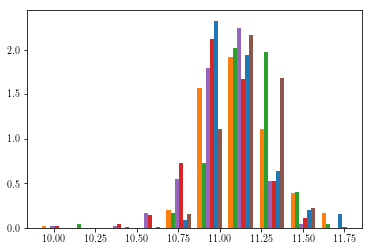

In [44]:
plt.hist([mblack2['m10_aper'],bahamas['m10_aper'],horizon['m10_aper'], illustris_m_1d_10, tng_m_1d_10, fastMaster['logm_10']],
        normed=True)

# PLOTS

## Mtotal 

/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


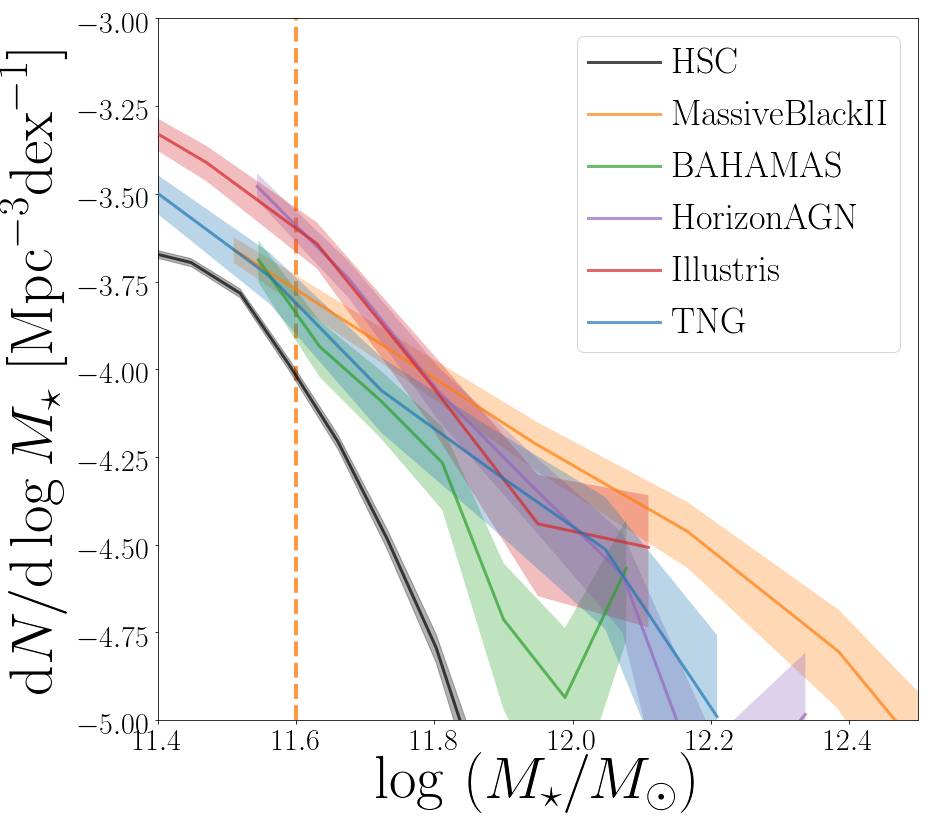

In [40]:
fig = plt.figure(figsize=(13, 12))
fig.subplots_adjust(left=0.22, right=0.995, 
                    bottom=0.14, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
# ax1 = plotting.songAxisSetup(
#     ax1, xlabel=50, ylabel=50, border=6.5,
#     xtickFormat='$\mathrm{%4.1f}$', 
#     ytickFormat='$\mathrm{%4.1f\ }$')


# S16A
# ax1.fill_between(mbin, s16aMLow5, s16aMUpp5, 
#                  facecolor=BLK(0.5), 
#                  edgecolor='none', alpha=0.3, 
#                  zorder=0, rasterized=True)

#HSC
ax1.plot(m_hsc, np.log10(smf_hsc), c='k', linestyle='-', linewidth=3.0, label=r'$\mathrm{HSC}\ $', zorder=2, alpha=0.7, rasterized=True)
ax1.fill_between(m_hsc, np.log10(smf_hsc-err_hsc), np.log10(smf_hsc+err_hsc), color='k', alpha=0.3, rasterized=True)
    
# Massive Black II 
ax1.plot(m_MB2, np.log10(smf_MB2), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7,label=r'$\mathrm{MassiveBlackII}$', rasterized=True) 
ax1.fill_between(m_MB2, np.log10(smf_MB2-err_MB2), np.log10(smf_MB2+err_MB2), alpha=0.3, rasterized=True)

# Bahamas
ax1.plot(m_BAHAMAS, np.log10(smf_BAHAMAS), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{BAHAMAS}$', rasterized=True)
ax1.fill_between(m_BAHAMAS, np.log10(smf_BAHAMAS-err_BAHAMAS), np.log10(smf_BAHAMAS+err_BAHAMAS), alpha=0.3, rasterized=True)

# Horizon
ax1.plot(m_horizon, np.log10(smf_horizon), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{HorizonAGN}$', rasterized=True)
ax1.fill_between(m_horizon, np.log10(smf_horizon-err_horizon), np.log10(smf_horizon+err_horizon), alpha=0.3, rasterized=True)

#Illustris
ax1.plot(m_illustris,np.log10(smf_illustris), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{Illustris}$', rasterized=True)
ax1.fill_between(m_illustris, np.log10(smf_illustris-err_illustris), np.log10(smf_illustris+err_illustris), alpha=0.3, rasterized=True)

#TNG
ax1.plot(m_tng,np.log10(smf_tng), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{TNG}$', rasterized=True)
ax1.fill_between(m_tng, np.log10(smf_tng-err_tng), np.log10(smf_tng+err_tng), alpha=0.3, rasterized=True)

# Legend
ax1.legend(loc='upper right', fontsize=36, markerscale=1.2, borderpad=0.3, handletextpad=0.34)

# X-Y limits
ax1.set_xlim(11.4, 12.5)
ax1.set_ylim(-5, -3)

# Label
ax1.set_xlabel(r'$\log\ (M_{\star}/M_{\odot})$', 
               size=60)
ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
               size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)

#ax1.text(11.8, -3.7, r'$\mathrm{Normalized}$', size=60)
ax1.axvline(11.6, linestyle='--', linewidth=4.0, alpha=0.8, zorder=0)

#prevent top from disappearing
plt.tight_layout()
plt.subplots_adjust(top=0.94)

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/SMF_sims+HSC.pdf', dpi=100, format='pdf')
#eps doesn't show alpha

plt.show()

## M10

/Users/fardila/anaconda2/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda2/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


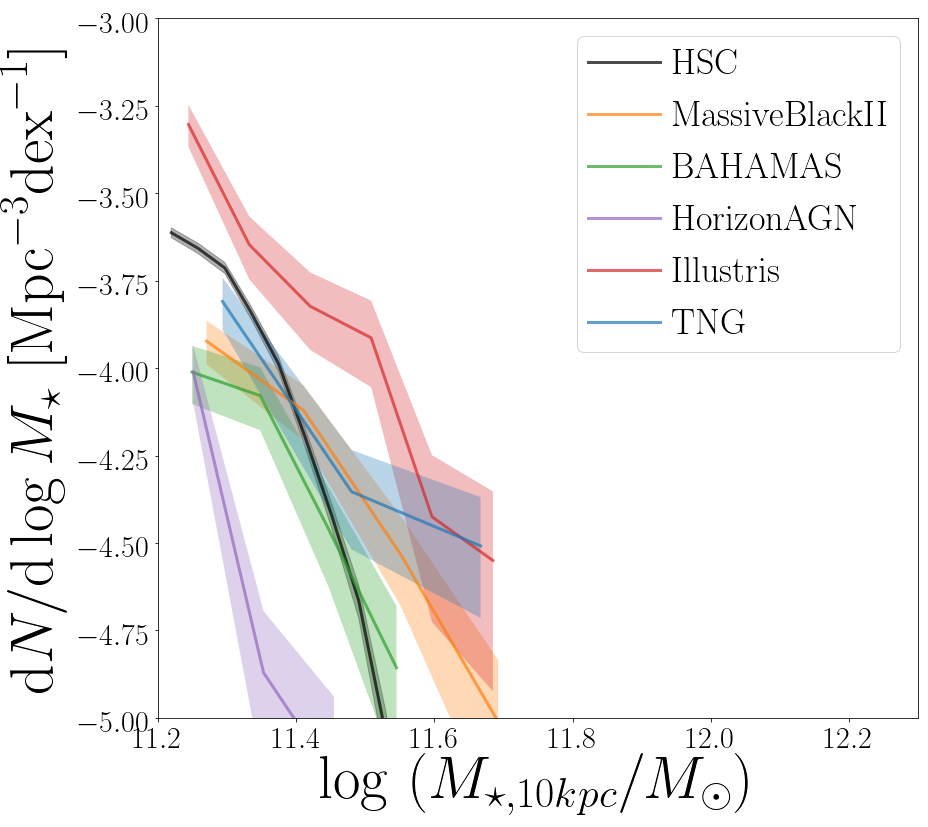

In [23]:
fig = plt.figure(figsize=(13, 12))
fig.subplots_adjust(left=0.22, right=0.995, 
                    bottom=0.14, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
# ax1 = plotting.songAxisSetup(
#     ax1, xlabel=50, ylabel=50, border=6.5,
#     xtickFormat='$\mathrm{%4.1f}$', 
#     ytickFormat='$\mathrm{%4.1f\ }$')


# S16A
# ax1.fill_between(mbin, s16aMLow5, s16aMUpp5, 
#                  facecolor=BLK(0.5), 
#                  edgecolor='none', alpha=0.3, 
#                  zorder=0, rasterized=True)

#HSC
ax1.plot(m10_hsc, np.log10(smf10_hsc), c='k', linestyle='-', linewidth=3.0, label=r'$\mathrm{HSC}\ $', zorder=2, alpha=0.7)
ax1.fill_between(m10_hsc, np.log10(smf10_hsc-err10_hsc), np.log10(smf10_hsc+err10_hsc), alpha=0.3, rasterized=True,
                 color='k')
   
# Massive Black II 
ax1.plot(m10_MB2, np.log10(smf10_MB2), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7,label=r'$\mathrm{MassiveBlackII}$') 
ax1.fill_between(m10_MB2, np.log10(smf10_MB2-err10_MB2), np.log10(smf10_MB2+err10_MB2), alpha=0.3, rasterized=True)

# Bahamas
ax1.plot(m10_BAHAMAS, np.log10(smf10_BAHAMAS), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{BAHAMAS}$')
ax1.fill_between(m10_BAHAMAS, np.log10(smf10_BAHAMAS-err10_BAHAMAS), np.log10(smf10_BAHAMAS+err10_BAHAMAS), 
                 alpha=0.3, rasterized=True)

# Horizon
ax1.plot(m10_horizon, np.log10(smf10_horizon), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{HorizonAGN}$')
ax1.fill_between(m10_horizon, np.log10(smf10_horizon-err10_horizon), np.log10(smf10_horizon+err10_horizon), alpha=0.3, rasterized=True)

#Illustris
ax1.plot(m10_illustris,np.log10(smf10_illustris), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{Illustris}$')
ax1.fill_between(m10_illustris, np.log10(smf10_illustris-err10_illustris), np.log10(smf10_illustris+err10_illustris), 
                 alpha=0.3, rasterized=True)

#TNG
ax1.plot(m10_tng,np.log10(smf10_tng), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{TNG}$')
ax1.fill_between(m10_tng, np.log10(smf10_tng-err10_tng), np.log10(smf10_tng+err10_tng), alpha=0.3, rasterized=True)

# Legend
ax1.legend(loc='upper right', fontsize=36, markerscale=1.2, borderpad=0.3, handletextpad=0.34)

# X-Y limits
ax1.set_xlim(11.2, 12.3)
ax1.set_ylim(-5, -3)

# Label
ax1.set_xlabel(r'$\log\ (M_{\star, 10kpc}/M_{\odot})$', 
               size=60)
ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
               size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)

#ax1.text(11.8, -3.7, r'$\mathrm{Normalized}$', size=60)

# ax1.axvline(11.6, linestyle='--', linewidth=4.0, alpha=0.8, zorder=0)

#prevent top from disappearing
plt.tight_layout()
plt.subplots_adjust(top=0.94)

#fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/SMF10_sims+HSC.pdf', dpi=100, format='pdf')

#plt.title(r'$M_{\star\_10}$',size=60)
plt.show()

/Users/fardila/anaconda2/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda2/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


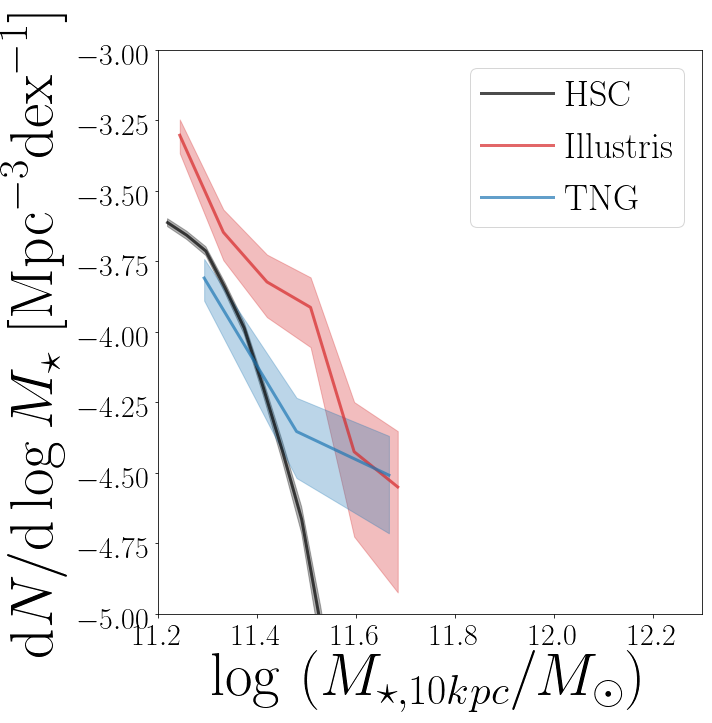

In [30]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.22, right=0.995, 
                    bottom=0.14, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
# ax1 = plotting.songAxisSetup(
#     ax1, xlabel=50, ylabel=50, border=6.5,
#     xtickFormat='$\mathrm{%4.1f}$', 
#     ytickFormat='$\mathrm{%4.1f\ }$')


# S16A
# ax1.fill_between(mbin, s16aMLow5, s16aMUpp5, 
#                  facecolor=BLK(0.5), 
#                  edgecolor='none', alpha=0.3, 
#                  zorder=0, rasterized=True)

#HSC
ax1.plot(m10_hsc, np.log10(smf10_hsc), c='k', linestyle='-', linewidth=3.0, label=r'$\mathrm{HSC}\ $', zorder=2, alpha=0.7)
ax1.fill_between(m10_hsc, np.log10(smf10_hsc-err10_hsc), np.log10(smf10_hsc+err10_hsc), alpha=0.3, rasterized=True,
                 color='k')
   

#Illustris
ax1.plot(m10_illustris,np.log10(smf10_illustris), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7,
         color=illustris_color, label=r'$\mathrm{Illustris}$')
ax1.fill_between(m10_illustris, np.log10(smf10_illustris-err10_illustris), np.log10(smf10_illustris+err10_illustris), 
                 color=illustris_color, alpha=0.3, rasterized=True)

#TNG
ax1.plot(m10_tng,np.log10(smf10_tng), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7,
         color=tng_color, label=r'$\mathrm{TNG}$')
ax1.fill_between(m10_tng, np.log10(smf10_tng-err10_tng), np.log10(smf10_tng+err10_tng), alpha=0.3,
         color=tng_color, rasterized=True)

# Legend
ax1.legend(loc='upper right', fontsize=36, markerscale=1.2, borderpad=0.3, handletextpad=0.34)

# X-Y limits
ax1.set_xlim(11.2, 12.3)
ax1.set_ylim(-5, -3)

# Label
ax1.set_xlabel(r'$\log\ (M_{\star, 10kpc}/M_{\odot})$', 
               size=60)
ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
               size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)

#ax1.text(11.8, -3.7, r'$\mathrm{Normalized}$', size=60)

# ax1.axvline(11.6, linestyle='--', linewidth=4.0, alpha=0.8, zorder=0)

#prevent top from disappearing
plt.tight_layout()
plt.subplots_adjust(top=0.94)

fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/SMF10_Illustris+TNG+HSC.pdf', dpi=100, format='pdf')

#plt.title(r'$M_{\star\_10}$',size=60)
plt.show()

## M_30

/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


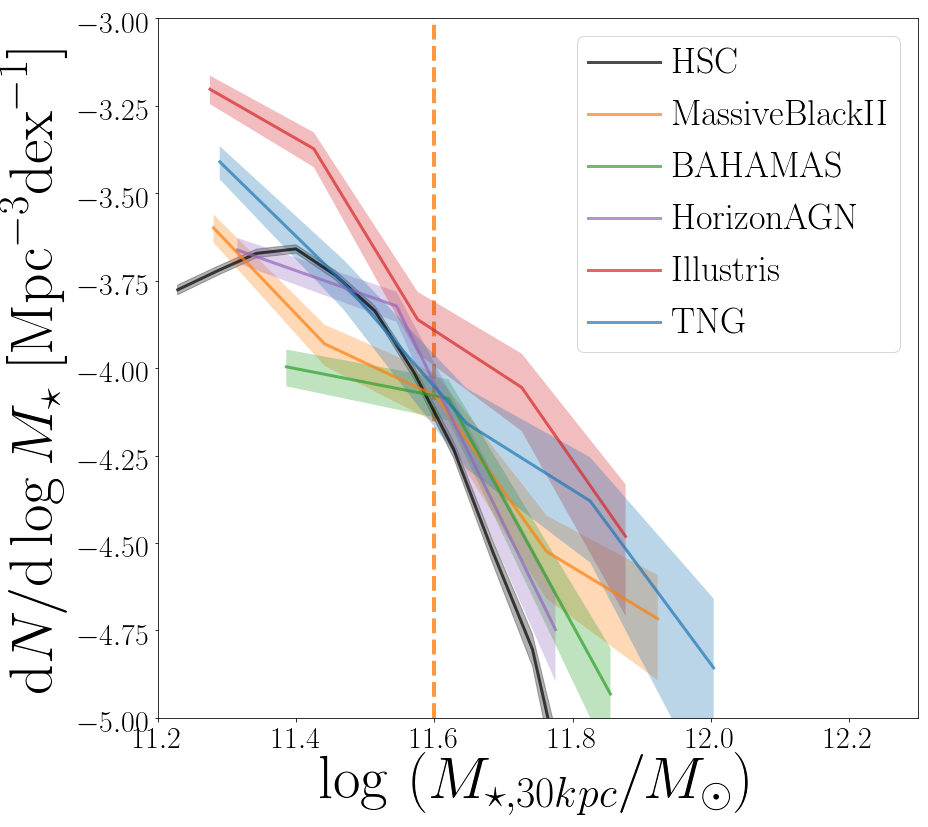

In [44]:
fig = plt.figure(figsize=(13, 12))
fig.subplots_adjust(left=0.22, right=0.995, 
                    bottom=0.14, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
# ax1 = plotting.songAxisSetup(
#     ax1, xlabel=50, ylabel=50, border=6.5,
#     xtickFormat='$\mathrm{%4.1f}$', 
#     ytickFormat='$\mathrm{%4.1f\ }$')


# S16A
# ax1.fill_between(mbin, s16aMLow5, s16aMUpp5, 
#                  facecolor=BLK(0.5), 
#                  edgecolor='none', alpha=0.3, 
#                  zorder=0, rasterized=True)

#HSC
ax1.plot(m30_hsc, np.log10(smf30_hsc), c='k', linestyle='-', linewidth=3.0, label=r'$\mathrm{HSC}\ $', zorder=2, alpha=0.7)
ax1.fill_between(m30_hsc, np.log10(smf30_hsc-err30_hsc), np.log10(smf30_hsc+err30_hsc), alpha=0.3, rasterized=True,
                 color='k')
   
# Massive Black II 
ax1.plot(m30_MB2, np.log10(smf30_MB2), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7,label=r'$\mathrm{MassiveBlackII}$') 
ax1.fill_between(m30_MB2, np.log10(smf30_MB2-err30_MB2), np.log10(smf30_MB2+err30_MB2), alpha=0.3, rasterized=True)

# Bahamas
ax1.plot(m30_BAHAMAS, np.log10(smf30_BAHAMAS), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{BAHAMAS}$')
ax1.fill_between(m30_BAHAMAS, np.log10(smf30_BAHAMAS-err30_BAHAMAS), np.log10(smf30_BAHAMAS+err30_BAHAMAS), 
                 alpha=0.3, rasterized=True)

# Horizon
ax1.plot(m30_horizon, np.log10(smf30_horizon), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{HorizonAGN}$')
ax1.fill_between(m30_horizon, np.log10(smf30_horizon-err30_horizon), np.log10(smf30_horizon+err30_horizon), alpha=0.3, rasterized=True)

#Illustris
ax1.plot(m30_illustris,np.log10(smf30_illustris), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{Illustris}$')
ax1.fill_between(m30_illustris, np.log10(smf30_illustris-err30_illustris), np.log10(smf30_illustris+err30_illustris), 
                 alpha=0.3, rasterized=True)

#TNG
ax1.plot(m30_tng,np.log10(smf30_tng), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{TNG}$')
ax1.fill_between(m30_tng, np.log10(smf30_tng-err30_tng), np.log10(smf30_tng+err30_tng), alpha=0.3, rasterized=True)

# Legend
ax1.legend(loc='upper right', fontsize=36, markerscale=1.2, borderpad=0.3, handletextpad=0.34)

# X-Y limits
ax1.set_xlim(11.2, 12.3)
ax1.set_ylim(-5, -3)

# Label
ax1.set_xlabel(r'$\log\ (M_{\star, 30kpc}/M_{\odot})$', 
               size=60)
ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
               size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)

#ax1.text(11.8, -3.7, r'$\mathrm{Normalized}$', size=60)

ax1.axvline(11.6, linestyle='--', linewidth=4.0, alpha=0.8, zorder=0)

#prevent top from disappearing
plt.tight_layout()
plt.subplots_adjust(top=0.94)

#fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/SMF30_sims+HSC.pdf', dpi=100, format='pdf')

#plt.title(r'$M_{\star\_30}$',size=60)
plt.show()

## M100 

/Users/fardila/anaconda2/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/Users/fardila/anaconda2/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


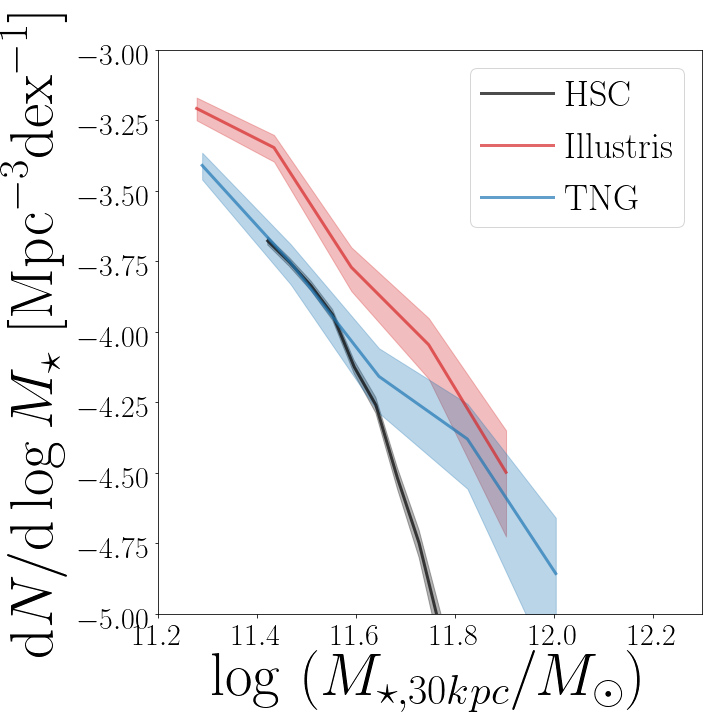

In [31]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.22, right=0.995, 
                    bottom=0.14, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)


#HSC
ax1.plot(m30_hsc, np.log10(smf30_hsc), c='k', linestyle='-', linewidth=3.0, label=r'$\mathrm{HSC}\ $', zorder=2, alpha=0.7)
ax1.fill_between(m30_hsc, np.log10(smf30_hsc-err30_hsc), np.log10(smf30_hsc+err30_hsc), alpha=0.3, rasterized=True,
                 color='k')
 
#Illustris
ax1.plot(m30_illustris,np.log10(smf30_illustris), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7,
         color=illustris_color, label=r'$\mathrm{Illustris}$')
ax1.fill_between(m30_illustris, np.log10(smf30_illustris-err30_illustris), np.log10(smf30_illustris+err30_illustris), 
                 color=illustris_color, alpha=0.3, rasterized=True)

#TNG
ax1.plot(m30_tng,np.log10(smf30_tng), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, 
         color=tng_color, label=r'$\mathrm{TNG}$')
ax1.fill_between(m30_tng, np.log10(smf30_tng-err30_tng), np.log10(smf30_tng+err30_tng),
                 color=tng_color, alpha=0.3, rasterized=True)

# Legend
ax1.legend(loc='upper right', fontsize=36, markerscale=1.2, borderpad=0.3, handletextpad=0.34)

# X-Y limits
ax1.set_xlim(11.2, 12.3)
ax1.set_ylim(-5, -3)

# Label
ax1.set_xlabel(r'$\log\ (M_{\star, 30kpc}/M_{\odot})$', 
               size=60)
ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
               size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)

#ax1.text(11.8, -3.7, r'$\mathrm{Normalized}$', size=60)

#  ax1.axvline(11.6, linestyle='--', linewidth=4.0, alpha=0.8, zorder=0)

#prevent top from disappearing
plt.tight_layout()
plt.subplots_adjust(top=0.94)

fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/SMF30_Illustris+TNG+HSC.pdf', dpi=100, format='pdf')

#plt.title(r'$M_{\star\_30}$',size=60)
plt.show()

## M_100

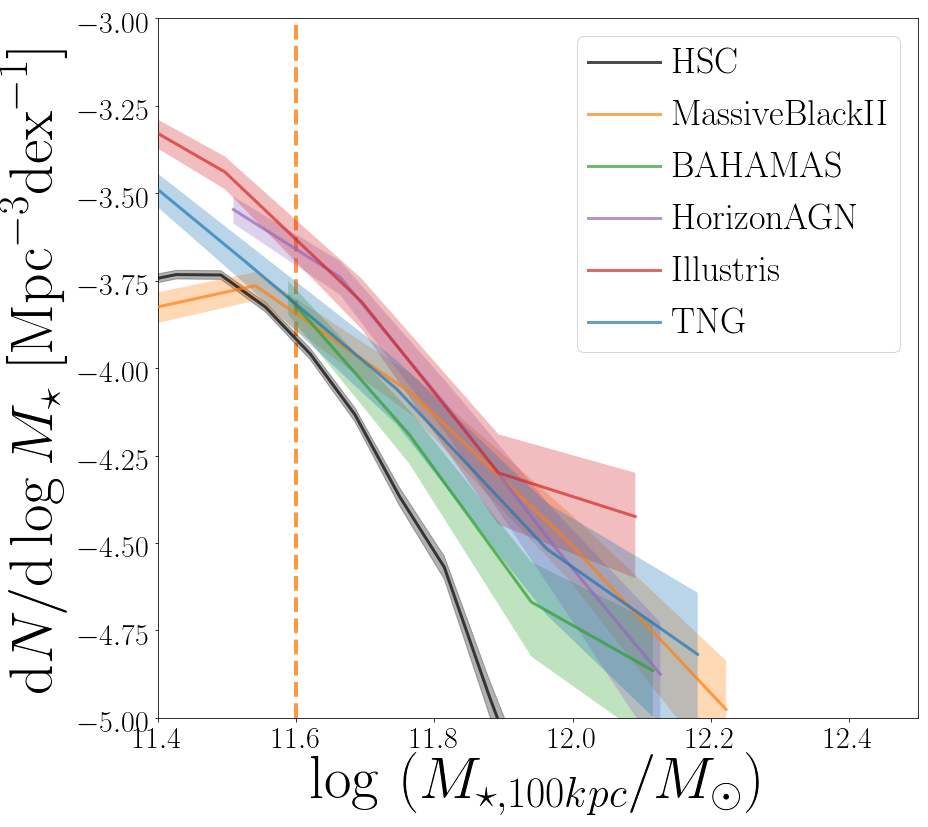

In [33]:
fig = plt.figure(figsize=(13, 12))
fig.subplots_adjust(left=0.22, right=0.995, 
                    bottom=0.14, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
# ax1 = plotting.songAxisSetup(
#     ax1, xlabel=50, ylabel=50, border=6.5,
#     xtickFormat='$\mathrm{%4.1f}$', 
#     ytickFormat='$\mathrm{%4.1f\ }$')


# S16A
# ax1.fill_between(mbin, s16aMLow5, s16aMUpp5, 
#                  facecolor=BLK(0.5), 
#                  edgecolor='none', alpha=0.3, 
#                  zorder=0, rasterized=True)

#HSC
ax1.plot(m100_hsc, np.log10(smf100_hsc), c='k', linestyle='-', linewidth=3.0, label=r'$\mathrm{HSC}\ $', zorder=2, alpha=0.7)
ax1.fill_between(m100_hsc, np.log10(smf100_hsc-err100_hsc), np.log10(smf100_hsc+err100_hsc), alpha=0.3, rasterized=True,
                 color='k')
   
# Massive Black II 
ax1.plot(m100_MB2, np.log10(smf100_MB2), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7,label=r'$\mathrm{MassiveBlackII}$') 
ax1.fill_between(m100_MB2, np.log10(smf100_MB2-err100_MB2), np.log10(smf100_MB2+err100_MB2), alpha=0.3, rasterized=True)

# Bahamas
ax1.plot(m100_BAHAMAS, np.log10(smf100_BAHAMAS), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{BAHAMAS}$')
ax1.fill_between(m100_BAHAMAS, np.log10(smf100_BAHAMAS-err100_BAHAMAS), np.log10(smf100_BAHAMAS+err100_BAHAMAS), 
                 alpha=0.3, rasterized=True)

# Horizon
ax1.plot(m100_horizon, np.log10(smf100_horizon), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{HorizonAGN}$')
ax1.fill_between(m100_horizon, np.log10(smf100_horizon-err100_horizon), np.log10(smf100_horizon+err100_horizon), alpha=0.3, rasterized=True)

#Illustris
ax1.plot(m100_illustris,np.log10(smf100_illustris), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{Illustris}$')
ax1.fill_between(m100_illustris, np.log10(smf100_illustris-err100_illustris), np.log10(smf100_illustris+err100_illustris), 
                 alpha=0.3, rasterized=True)

#TNG
ax1.plot(m100_tng,np.log10(smf100_tng), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{TNG}$')
ax1.fill_between(m100_tng, np.log10(smf100_tng-err100_tng), np.log10(smf100_tng+err100_tng), alpha=0.3, rasterized=True)

# Legend
ax1.legend(loc='upper right', fontsize=36, markerscale=1.2, borderpad=0.3, handletextpad=0.34)

# X-Y limits
ax1.set_xlim(11.4, 12.5)
ax1.set_ylim(-5, -3)

# Label
ax1.set_xlabel(r'$\log\ (M_{\star, 100kpc}/M_{\odot})$', 
               size=60)
ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
               size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)

#ax1.text(11.8, -3.7, r'$\mathrm{Normalized}$', size=60)

ax1.axvline(11.6, linestyle='--', linewidth=4.0, alpha=0.8, zorder=0)

#prevent top from disappearing
plt.tight_layout()
plt.subplots_adjust(top=0.94)

#fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/SMF100_sims+HSC.pdf', dpi=100, format='pdf')

#plt.title(r'$M_{\star\_100}$',size=60)
plt.show()

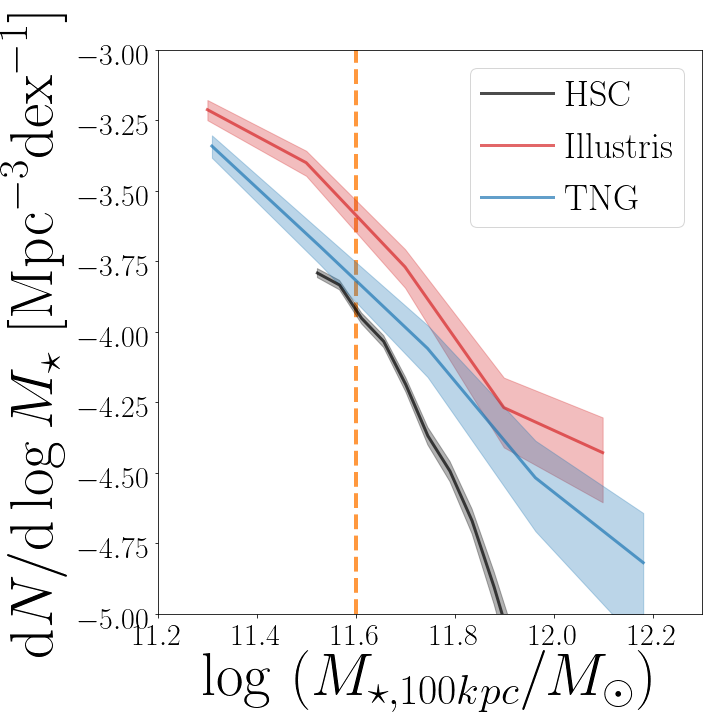

In [32]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.22, right=0.995, 
                    bottom=0.14, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
# ax1 = plotting.songAxisSetup(
#     ax1, xlabel=50, ylabel=50, border=6.5,
#     xtickFormat='$\mathrm{%4.1f}$', 
#     ytickFormat='$\mathrm{%4.1f\ }$')


# S16A
# ax1.fill_between(mbin, s16aMLow5, s16aMUpp5, 
#                  facecolor=BLK(0.5), 
#                  edgecolor='none', alpha=0.3, 
#                  zorder=0, rasterized=True)

#HSC
ax1.plot(m100_hsc, np.log10(smf100_hsc), c='k', linestyle='-', linewidth=3.0, label=r'$\mathrm{HSC}\ $', zorder=2, alpha=0.7)
ax1.fill_between(m100_hsc, np.log10(smf100_hsc-err100_hsc), np.log10(smf100_hsc+err100_hsc), alpha=0.3, rasterized=True,
                 color='k')
   
#Illustris
ax1.plot(m100_illustris,np.log10(smf100_illustris), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7,
         color=illustris_color, label=r'$\mathrm{Illustris}$')
ax1.fill_between(m100_illustris, np.log10(smf100_illustris-err100_illustris), np.log10(smf100_illustris+err100_illustris),
                 color=illustris_color,  alpha=0.3, rasterized=True)

#TNG
ax1.plot(m100_tng,np.log10(smf100_tng), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7,
         color=tng_color, label=r'$\mathrm{TNG}$')
ax1.fill_between(m100_tng, np.log10(smf100_tng-err100_tng), np.log10(smf100_tng+err100_tng),
                 color=tng_color, alpha=0.3, rasterized=True)

# Legend
ax1.legend(loc='upper right', fontsize=36, markerscale=1.2, borderpad=0.3, handletextpad=0.34)

# X-Y limits
ax1.set_xlim(11.2, 12.3)
ax1.set_ylim(-5, -3)

# Label
ax1.set_xlabel(r'$\log\ (M_{\star, 100kpc}/M_{\odot})$', 
               size=60)
ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
               size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)

#ax1.text(11.8, -3.7, r'$\mathrm{Normalized}$', size=60)

ax1.axvline(11.6, linestyle='--', linewidth=4.0, alpha=0.8, zorder=0)

#prevent top from disappearing
plt.tight_layout()
plt.subplots_adjust(top=0.94)

fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/SMF100_Illustris+TNG+HSC.pdf', dpi=100, format='pdf')

#plt.title(r'$M_{\star\_100}$',size=60)
plt.show()

## Number of galaxies with $M_{100} > 11.8$

In [36]:
print 'MassiveBlackII has %d galaxies with log(M_star) > 11.8' % np.sum([mblack2['m100_aper']>11.8])
print 'BAHAMAS has %d galaxies with log(M_star) > 11.8' % np.sum([bahamas['m100_aper']>11.8])
print 'Horizon-AGN has %d galaxies with log(M_star) > 11.8' % np.sum([horizon['m100_aper']>11.8])
print 'Illustris has %d galaxies with log(M_star) > 11.8' % np.sum([illustris_masses['m_1d_100']>11.8])
print 'TNG has %d galaxies with log(M_star) > 11.8' % np.sum([tng_masses['m_1d_100'] >11.8])
print 'HSC has %d galaxies with log(M_star) > 11.8' % np.sum([fastMaster['logm_100']>11.8])

MassiveBlackII has 46 galaxies with log(M_star) > 11.8
BAHAMAS has 26 galaxies with log(M_star) > 11.8
Horizon-AGN has 37 galaxies with log(M_star) > 11.8
Illustris has 22 galaxies with log(M_star) > 11.8
TNG has 19 galaxies with log(M_star) > 11.8
HSC has 265 galaxies with log(M_star) > 11.8


## put all 3 plots together to share axes

/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:55: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: divide by zero encountered in log10


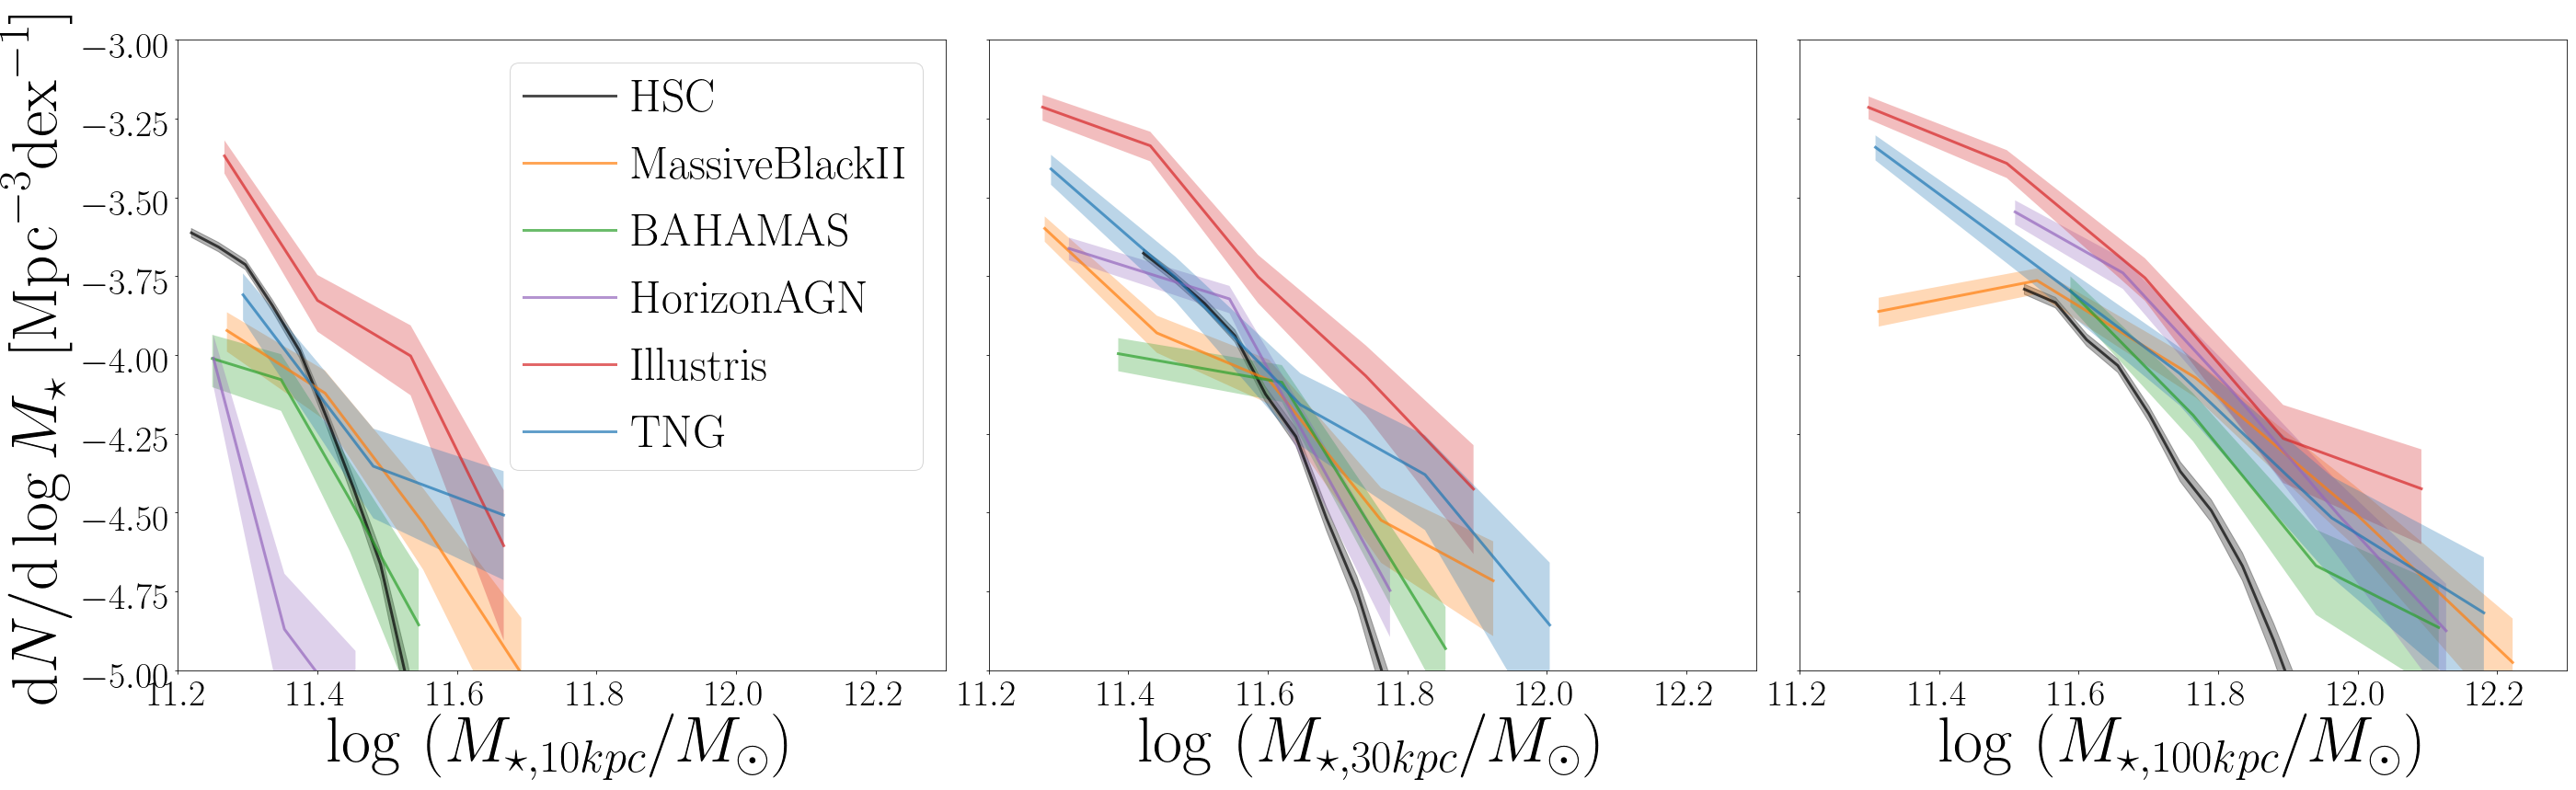

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(13*3, 12))
fig.subplots_adjust(left=0.22, right=0.995, bottom=0.14, top=0.94, wspace=0.00, hspace=0.00)

######################################################################################################################
#ax1: total M_star_10kpc
######################################################################################################################
#HSC
ax1.plot(m10_hsc, np.log10(smf10_hsc), c='k', linestyle='-', linewidth=3.0, label=r'$\mathrm{HSC}\ $', zorder=2, alpha=0.7)
ax1.fill_between(m10_hsc, np.log10(smf10_hsc-err10_hsc), np.log10(smf10_hsc+err10_hsc), alpha=0.3, rasterized=True,
                 color='k')
   
# Massive Black II 
ax1.plot(m10_MB2, np.log10(smf10_MB2), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7,label=r'$\mathrm{MassiveBlackII}$') 
ax1.fill_between(m10_MB2, np.log10(smf10_MB2-err10_MB2), np.log10(smf10_MB2+err10_MB2), alpha=0.3, rasterized=True)

# Bahamas
ax1.plot(m10_BAHAMAS, np.log10(smf10_BAHAMAS), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{BAHAMAS}$')
ax1.fill_between(m10_BAHAMAS, np.log10(smf10_BAHAMAS-err10_BAHAMAS), np.log10(smf10_BAHAMAS+err10_BAHAMAS), 
                 alpha=0.3, rasterized=True)

# Horizon
ax1.plot(m10_horizon, np.log10(smf10_horizon), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{HorizonAGN}$')
ax1.fill_between(m10_horizon, np.log10(smf10_horizon-err10_horizon), np.log10(smf10_horizon+err10_horizon), alpha=0.3, rasterized=True)

#Illustris
ax1.plot(m10_illustris,np.log10(smf10_illustris), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{Illustris}$')
ax1.fill_between(m10_illustris, np.log10(smf10_illustris-err10_illustris), np.log10(smf10_illustris+err10_illustris), 
                 alpha=0.3, rasterized=True)

#TNG
ax1.plot(m10_tng,np.log10(smf10_tng), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{TNG}$')
ax1.fill_between(m10_tng, np.log10(smf10_tng-err10_tng), np.log10(smf10_tng+err10_tng), alpha=0.3, rasterized=True)

# Legend
# ax1.legend(loc='upper right', fontsize=36, markerscale=1.2, borderpad=0.3, handletextpad=0.34)

# X-Y limits
ax1.set_xlim(11.2, 12.3)
ax1.set_ylim(-5, -3)

# Label
ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
               size=70)
# ax1.set_xlabel(r'$\log\ (M_{\star, 10kpc}/M_{\odot})$', 
#                size=100)
ax1.set_xlabel(r'$\log\ (M_{\star, 10kpc}/M_{\odot})$', 
               size=70)
ax1.tick_params(axis='both', which='major', labelsize=40)


######################################################################################################################
#ax2: total M_star_30kpc
######################################################################################################################
#HSC
ax2.plot(m30_hsc, np.log10(smf30_hsc), c='k', linestyle='-', linewidth=3.0, label=r'$\mathrm{HSC}\ $', zorder=2, alpha=0.7)
ax2.fill_between(m30_hsc, np.log10(smf30_hsc-err30_hsc), np.log10(smf30_hsc+err30_hsc), alpha=0.3, rasterized=True,
                 color='k')
   
# Massive Black II 
ax2.plot(m30_MB2, np.log10(smf30_MB2), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7,label=r'$\mathrm{MassiveBlackII}$') 
ax2.fill_between(m30_MB2, np.log10(smf30_MB2-err30_MB2), np.log10(smf30_MB2+err30_MB2), alpha=0.3, rasterized=True)

# Bahamas
ax2.plot(m30_BAHAMAS, np.log10(smf30_BAHAMAS), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{BAHAMAS}$')
ax2.fill_between(m30_BAHAMAS, np.log10(smf30_BAHAMAS-err30_BAHAMAS), np.log10(smf30_BAHAMAS+err30_BAHAMAS), 
                 alpha=0.3, rasterized=True)

# Horizon
ax2.plot(m30_horizon, np.log10(smf30_horizon), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{HorizonAGN}$')
ax2.fill_between(m30_horizon, np.log10(smf30_horizon-err30_horizon), np.log10(smf30_horizon+err30_horizon), alpha=0.3, rasterized=True)

#Illustris
ax2.plot(m30_illustris,np.log10(smf30_illustris), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{Illustris}$')
ax2.fill_between(m30_illustris, np.log10(smf30_illustris-err30_illustris), np.log10(smf30_illustris+err30_illustris), 
                 alpha=0.3, rasterized=True)

#TNG
ax2.plot(m30_tng,np.log10(smf30_tng), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{TNG}$')
ax2.fill_between(m30_tng, np.log10(smf30_tng-err30_tng), np.log10(smf30_tng+err30_tng), alpha=0.3, rasterized=True)

# X-Y limits
ax2.set_xlim(11.2, 12.3)
ax2.set_ylim(-5, -3)

# Label
# ax2.set_xlabel(r'$\log\ (M_{\star, 30kpc}/M_{\odot})$', 
#                size=100)
ax2.set_xlabel(r'$\log\ (M_{\star, 30kpc}/M_{\odot})$', 
               size=70)
ax2.tick_params(axis='x', which='major', labelsize=40)

# ax2.axvline(11.6, linestyle='--', linewidth=4.0, alpha=0.8, zorder=0)


######################################################################################################################
#ax3: total M_star_100kpc
######################################################################################################################
#HSC
ax3.plot(m100_hsc, np.log10(smf100_hsc), c='k', linestyle='-', linewidth=3.0, label=r'$\mathrm{HSC}\ $', zorder=2, alpha=0.7)
ax3.fill_between(m100_hsc, np.log10(smf100_hsc-err100_hsc), np.log10(smf100_hsc+err100_hsc), alpha=0.3, rasterized=True,
                 color='k')
   
# Massive Black II 
ax3.plot(m100_MB2, np.log10(smf100_MB2), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7,label=r'$\mathrm{MassiveBlackII}$') 
ax3.fill_between(m100_MB2, np.log10(smf100_MB2-err100_MB2), np.log10(smf100_MB2+err100_MB2), alpha=0.3, rasterized=True)

# Bahamas
ax3.plot(m100_BAHAMAS, np.log10(smf100_BAHAMAS), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{BAHAMAS}$')
ax3.fill_between(m100_BAHAMAS, np.log10(smf100_BAHAMAS-err100_BAHAMAS), np.log10(smf100_BAHAMAS+err100_BAHAMAS), 
                 alpha=0.3, rasterized=True)

# Horizon
ax3.plot(m100_horizon, np.log10(smf100_horizon), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{HorizonAGN}$')
ax3.fill_between(m100_horizon, np.log10(smf100_horizon-err100_horizon), np.log10(smf100_horizon+err100_horizon), alpha=0.3, rasterized=True)

#Illustris
ax3.plot(m100_illustris,np.log10(smf100_illustris), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{Illustris}$')
ax3.fill_between(m100_illustris, np.log10(smf100_illustris-err100_illustris), np.log10(smf100_illustris+err100_illustris), 
                 alpha=0.3, rasterized=True)

#TNG
ax3.plot(m100_tng,np.log10(smf100_tng), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{TNG}$')
ax3.fill_between(m100_tng, np.log10(smf100_tng-err100_tng), np.log10(smf100_tng+err100_tng), alpha=0.3, rasterized=True)

# X-Y limits
ax3.set_xlim(11.2, 12.3)
ax3.set_ylim(-5, -3)

# Label
# ax3.set_xlabel(r'$\log\ (M_{\star, 100kpc}/M_{\odot})$', 
#                size=100) #size=100 for presentations
ax3.set_xlabel(r'$\log\ (M_{\star, 100kpc}/M_{\odot})$', 
               size=70)
ax3.tick_params(axis='x', which='major', labelsize=40)

# ax3.axvline(11.6, linestyle='--', linewidth=4.0, alpha=0.8, zorder=0)

######################################################################################################################
#adjustments to ticks and space between subplots

plt.setp([a.get_yticklabels() for a in fig.axes[1:]], visible=False)
# for a in fig.axes[1:]:
#     a.yaxis.set_ticks_position('none')

    
# Legend
ax1.legend(loc='upper right', fontsize=50, markerscale=1.2, borderpad=0.3, handletextpad=0.34)


#add a bit of space between subplots
plt.tight_layout()

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/SMFs_sims+HSC_side_by_side.pdf', dpi=100, format='pdf')

plt.show()

/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:59: RuntimeWarning: divide by zero encountered in log10


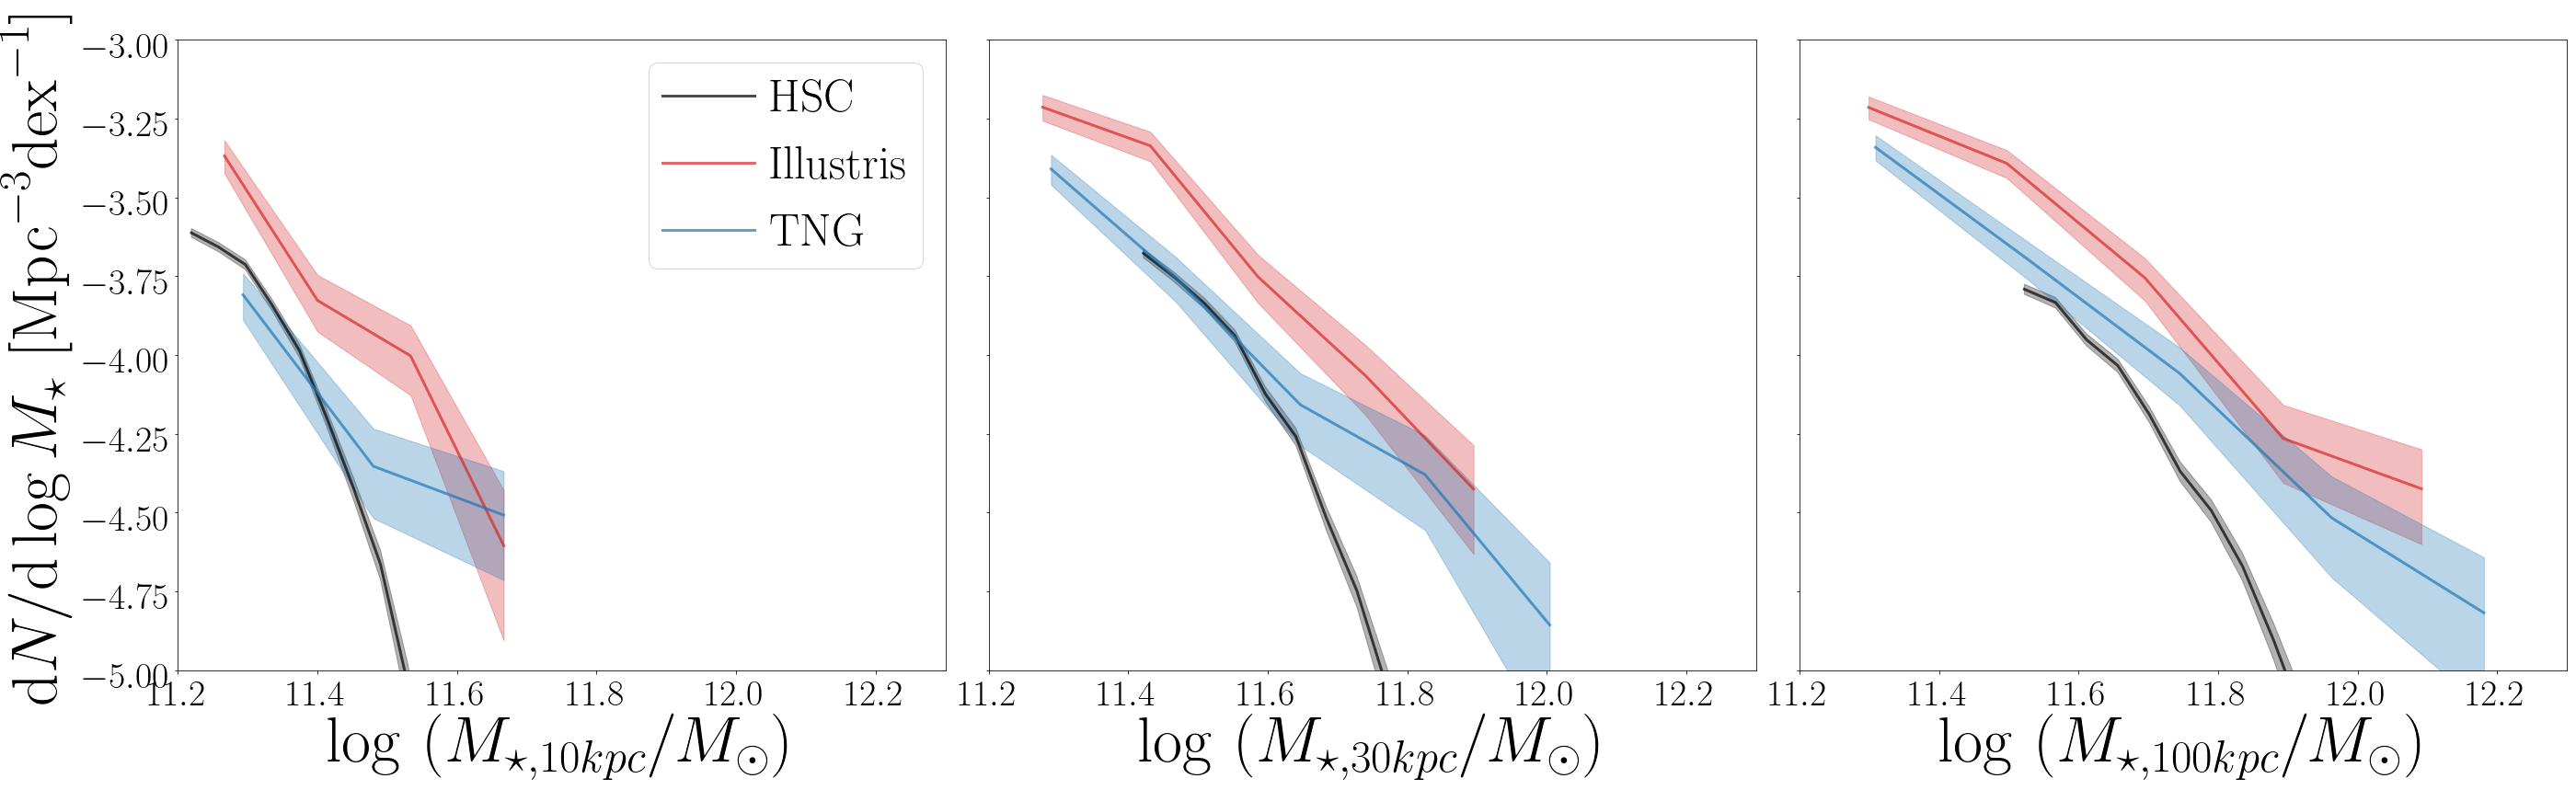

In [49]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(13*3, 12))
fig.subplots_adjust(left=0.22, right=0.995, bottom=0.14, top=0.94, wspace=0.00, hspace=0.00)

######################################################################################################################
#ax1: total M_star_10kpc
######################################################################################################################
#HSC
ax1.plot(m10_hsc, np.log10(smf10_hsc), c='k', linestyle='-', linewidth=3.0, label=r'$\mathrm{HSC}\ $', zorder=2, alpha=0.7)
ax1.fill_between(m10_hsc, np.log10(smf10_hsc-err10_hsc), np.log10(smf10_hsc+err10_hsc), alpha=0.3, rasterized=True,
                 color='k')
   
# # Massive Black II 
# ax1.plot(m10_MB2, np.log10(smf10_MB2), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7,label=r'$\mathrm{MassiveBlackII}$') 
# ax1.fill_between(m10_MB2, np.log10(smf10_MB2-err10_MB2), np.log10(smf10_MB2+err10_MB2), alpha=0.3, rasterized=True)

# # Bahamas
# ax1.plot(m10_BAHAMAS, np.log10(smf10_BAHAMAS), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{BAHAMAS}$')
# ax1.fill_between(m10_BAHAMAS, np.log10(smf10_BAHAMAS-err10_BAHAMAS), np.log10(smf10_BAHAMAS+err10_BAHAMAS), 
#                  alpha=0.3, rasterized=True)

# # Horizon
# ax1.plot(m10_horizon, np.log10(smf10_horizon), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{HorizonAGN}$')
# ax1.fill_between(m10_horizon, np.log10(smf10_horizon-err10_horizon), np.log10(smf10_horizon+err10_horizon), alpha=0.3, rasterized=True)

#Illustris
ax1.plot(m10_illustris,np.log10(smf10_illustris), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7,
         color = illustris_color, label=r'$\mathrm{Illustris}$')
ax1.fill_between(m10_illustris, np.log10(smf10_illustris-err10_illustris), np.log10(smf10_illustris+err10_illustris), 
                 alpha=0.3, rasterized=True, color = illustris_color)

#TNG
ax1.plot(m10_tng,np.log10(smf10_tng), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7,
         color=tng_color, label=r'$\mathrm{TNG}$')
ax1.fill_between(m10_tng, np.log10(smf10_tng-err10_tng), np.log10(smf10_tng+err10_tng), alpha=0.3, rasterized=True,
                color = tng_color)

# Legend
# ax1.legend(loc='upper right', fontsize=36, markerscale=1.2, borderpad=0.3, handletextpad=0.34)

# X-Y limits
ax1.set_xlim(11.2, 12.3)
ax1.set_ylim(-5, -3)

# Label
ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
               size=70)
# ax1.set_xlabel(r'$\log\ (M_{\star, 10kpc}/M_{\odot})$', 
#                size=100)
ax1.set_xlabel(r'$\log\ (M_{\star, 10kpc}/M_{\odot})$', 
               size=70)
ax1.tick_params(axis='both', which='major', labelsize=40)


######################################################################################################################
#ax2: total M_star_30kpc
######################################################################################################################
#HSC
ax2.plot(m30_hsc, np.log10(smf30_hsc), c='k', linestyle='-', linewidth=3.0, label=r'$\mathrm{HSC}\ $', zorder=2, alpha=0.7)
ax2.fill_between(m30_hsc, np.log10(smf30_hsc-err30_hsc), np.log10(smf30_hsc+err30_hsc), alpha=0.3, rasterized=True,
                 color='k')
   
# # Massive Black II 
# ax2.plot(m30_MB2, np.log10(smf30_MB2), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7,label=r'$\mathrm{MassiveBlackII}$') 
# ax2.fill_between(m30_MB2, np.log10(smf30_MB2-err30_MB2), np.log10(smf30_MB2+err30_MB2), alpha=0.3, rasterized=True)

# # Bahamas
# ax2.plot(m30_BAHAMAS, np.log10(smf30_BAHAMAS), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{BAHAMAS}$')
# ax2.fill_between(m30_BAHAMAS, np.log10(smf30_BAHAMAS-err30_BAHAMAS), np.log10(smf30_BAHAMAS+err30_BAHAMAS), 
#                  alpha=0.3, rasterized=True)

# # Horizon
# ax2.plot(m30_horizon, np.log10(smf30_horizon), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{HorizonAGN}$')
# ax2.fill_between(m30_horizon, np.log10(smf30_horizon-err30_horizon), np.log10(smf30_horizon+err30_horizon), alpha=0.3, rasterized=True)

#Illustris
ax2.plot(m30_illustris,np.log10(smf30_illustris), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7,
         color = illustris_color, label=r'$\mathrm{Illustris}$')
ax2.fill_between(m30_illustris, np.log10(smf30_illustris-err30_illustris), np.log10(smf30_illustris+err30_illustris), 
                 color = illustris_color, alpha=0.3, rasterized=True)

#TNG
ax2.plot(m30_tng,np.log10(smf30_tng), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7,
         color =tng_color, label=r'$\mathrm{TNG}$')
ax2.fill_between(m30_tng, np.log10(smf30_tng-err30_tng), np.log10(smf30_tng+err30_tng),
                 color =tng_color, alpha=0.3, rasterized=True)

# X-Y limits
ax2.set_xlim(11.2, 12.3)
ax2.set_ylim(-5, -3)

# Label
# ax2.set_xlabel(r'$\log\ (M_{\star, 30kpc}/M_{\odot})$', 
#                size=100)
ax2.set_xlabel(r'$\log\ (M_{\star, 30kpc}/M_{\odot})$', 
               size=70)
ax2.tick_params(axis='x', which='major', labelsize=40)

# ax2.axvline(11.6, linestyle='--', linewidth=4.0, alpha=0.8, zorder=0)


######################################################################################################################
#ax3: total M_star_100kpc
######################################################################################################################
#HSC
ax3.plot(m100_hsc, np.log10(smf100_hsc), c='k', linestyle='-', linewidth=3.0, label=r'$\mathrm{HSC}\ $', zorder=2, alpha=0.7)
ax3.fill_between(m100_hsc, np.log10(smf100_hsc-err100_hsc), np.log10(smf100_hsc+err100_hsc), alpha=0.3, rasterized=True,
                 color='k')
   
# # Massive Black II 
# ax3.plot(m100_MB2, np.log10(smf100_MB2), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7,label=r'$\mathrm{MassiveBlackII}$') 
# ax3.fill_between(m100_MB2, np.log10(smf100_MB2-err100_MB2), np.log10(smf100_MB2+err100_MB2), alpha=0.3, rasterized=True)

# # Bahamas
# ax3.plot(m100_BAHAMAS, np.log10(smf100_BAHAMAS), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{BAHAMAS}$')
# ax3.fill_between(m100_BAHAMAS, np.log10(smf100_BAHAMAS-err100_BAHAMAS), np.log10(smf100_BAHAMAS+err100_BAHAMAS), 
#                  alpha=0.3, rasterized=True)

# # Horizon
# ax3.plot(m100_horizon, np.log10(smf100_horizon), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7, label=r'$\mathrm{HorizonAGN}$')
# ax3.fill_between(m100_horizon, np.log10(smf100_horizon-err100_horizon), np.log10(smf100_horizon+err100_horizon), alpha=0.3, rasterized=True)

#Illustris
ax3.plot(m100_illustris,np.log10(smf100_illustris), linestyle='-', linewidth=3.0, zorder=5,
         color = illustris_color, alpha=0.7, label=r'$\mathrm{Illustris}$')
ax3.fill_between(m100_illustris, np.log10(smf100_illustris-err100_illustris), np.log10(smf100_illustris+err100_illustris), 
                 color = illustris_color, alpha=0.3, rasterized=True)

#TNG
ax3.plot(m100_tng,np.log10(smf100_tng), linestyle='-', linewidth=3.0, zorder=5, alpha=0.7,
         color =tng_color, label=r'$\mathrm{TNG}$')
ax3.fill_between(m100_tng, np.log10(smf100_tng-err100_tng), np.log10(smf100_tng+err100_tng), alpha=0.3,
                 color =tng_color, rasterized=True)

# X-Y limits
ax3.set_xlim(11.2, 12.3)
ax3.set_ylim(-5, -3)

# Label
# ax3.set_xlabel(r'$\log\ (M_{\star, 100kpc}/M_{\odot})$', 
#                size=100) #size=100 for presentations
ax3.set_xlabel(r'$\log\ (M_{\star, 100kpc}/M_{\odot})$', 
               size=70)
ax3.tick_params(axis='x', which='major', labelsize=40)

# ax3.axvline(11.6, linestyle='--', linewidth=4.0, alpha=0.8, zorder=0)

######################################################################################################################
#adjustments to ticks and space between subplots

plt.setp([a.get_yticklabels() for a in fig.axes[1:]], visible=False)
# for a in fig.axes[1:]:
#     a.yaxis.set_ticks_position('none')

    
# Legend
ax1.legend(loc='upper right', fontsize=50, markerscale=1.2, borderpad=0.3, handletextpad=0.34)


#add a bit of space between subplots
plt.tight_layout()

fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/SMFs_Illustris_TNG_HSC_3panel.pdf', dpi=100, format='pdf')

plt.show()